In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Data preparation
def preprocessing(filepath: str, resize_size: int = 64):
    X = []
    y = None
    with open('GENKI-4K_Images.txt') as f:
        for line in tqdm(f.readlines()):
            img_name = line.strip()
            img = Image.open(os.path.join(filepath, img_name)).convert("RGB").resize((resize_size, resize_size))
            # Normalize the image
            X.append(np.array(img).astype('float32')/255)
        X = np.array(X)

    with open('GENKI-4K_Labels.txt') as f1:
        y = [int(line.strip().split(' ')[0]) for line in tqdm(f1.readlines())]
        y = np.array(y)
    
    return X, y

In [3]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel, strides, padding):
        super(ConvBlock, self).__init__()
        self.cnn = Conv2D(filters, (kernel, kernel), strides=(strides, strides), kernel_initializer='he_normal', padding=padding)
        self.pool = MaxPool2D((2, 2), strides=(2, 2))
        self.batchnorm = BatchNormalization(momentum=0.9)
        
    def call(self, inputs):
        x = None
        x = self.cnn(inputs)
        x = self.batchnorm(x)
        x = tf.nn.relu(x)
        x = self.pool(x)
        return x

In [4]:
class CNNFig1(tf.keras.Model):
    def __init__(self, num_classes):
        super(CNNFig1, self).__init__()
        self.block1 = ConvBlock(64, kernel=3, strides=1, padding='same')
        self.block2 = ConvBlock(128, kernel=3, strides=1, padding='same')
        self.block3 = ConvBlock(256, kernel=3, strides=1, padding='same')
        self.block4 = ConvBlock(512, kernel=3, strides=1, padding='same')
        self.block5 = ConvBlock(1024, kernel=3, strides=1, padding='same')
        
        self.dropout = Dropout(rate=0.5)
        self.flatten = Flatten()
        self.globalpool = GlobalAveragePooling2D()
        
        self.dense = Dense(256, activation=tf.nn.relu, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.00025))
        self.dense1 = Dense(512, activation=tf.nn.relu, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0003))
        self.dense2 = Dense(num_classes)
        
    def call(self, inputs):
        x = None
        x = self.block1(inputs)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        
        x = self.flatten(x)
        # x = self.globalpool(x)
        x = self.dropout(x)
        
        x = self.dense(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        with tf.device('/cpu:0'):
            output = tf.nn.sigmoid(x)
        return output

In [ ]:
# Unzip the files.zip
!unzip files.zip
%cd ../content

In [6]:
num_classes = 1
X, y = preprocessing('./files')

print("\nThe shape of data is: {}".format(X.shape))
print("The shape of label is: {}".format(y.shape))

100%|██████████| 4000/4000 [00:00<00:00, 766222.87it/s]


The shape of data is: (4000, 64, 64, 3)
The shape of label is: (4000,)


In [7]:
# y = tf.keras.utils.to_categorical(np.array(labels), num_classes=num_classes)
# Split train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print("Train size: {}\t Validation size: {}".format(X_train.shape, X_test.shape))

Train size: (3200, 64, 64, 3)	 Validation size: (800, 64, 64, 3)


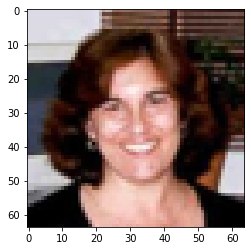

The class of this train image is Smile


In [8]:
# Test print
img_num = 141
plt.figure()
plt.imshow(X_train[img_num])
plt.show()
print("The class of this train image is {}".format("Smile" if y_train[img_num] == 1 else "Not Smile"))

Epoch 1/50
200/200 [==============================] - 4s 18ms/step - loss: 1.7672 - accuracy: 0.5269 - val_loss: 1.0199 - val_accuracy: 0.5400
Epoch 2/50
200/200 [==============================] - 3s 17ms/step - loss: 0.9887 - accuracy: 0.5841 - val_loss: 0.9087 - val_accuracy: 0.6363
Epoch 3/50
200/200 [==============================] - 3s 17ms/step - loss: 0.8861 - accuracy: 0.6368 - val_loss: 0.7397 - val_accuracy: 0.7588
Epoch 4/50
200/200 [==============================] - 3s 17ms/step - loss: 0.7196 - accuracy: 0.7423 - val_loss: 0.6027 - val_accuracy: 0.8062
Epoch 5/50
200/200 [==============================] - 4s 18ms/step - loss: 0.6221 - accuracy: 0.7984 - val_loss: 0.5500 - val_accuracy: 0.8125
Epoch 6/50
200/200 [==============================] - 4s 18ms/step - loss: 0.5321 - accuracy: 0.8395 - val_loss: 0.5735 - val_accuracy: 0.8100
Epoch 7/50
200/200 [==============================] - 4s 18ms/step - loss: 0.4741 - accuracy: 0.8581 - val_loss: 0.4757 - val_accuracy: 0.8288

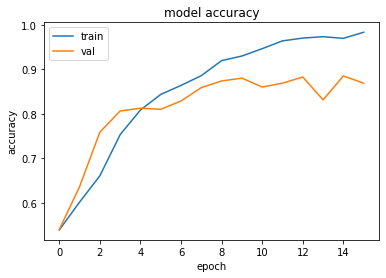

In [14]:
batch_size = 16
epochs = 50
with tf.device('/device:GPU:0'):
    model = CNNFig1(num_classes)
    mcp = ModelCheckpoint("my_model.h5", monitor="val_accuracy", save_best_only=True, save_weights_only=True)
    reduceLR = ReduceLROnPlateau(patience=7, verbose=1, factor=0.7, monitor="val_loss", mode='max')
    es = EarlyStopping(patience=6, monitor="val_loss")
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',
                    metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[mcp, reduceLR, es])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()